In [1]:
import torch
import os
import numpy as np
import pandas as pd
from utils import modify_metadata, TARGETS
from input_utils import TrainDataset
from model import EnsembleModel
from training import train, CV_score
import matplotlib.pyplot as plt

/home/barbora/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
n_folds = 5

In [3]:
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"
metadata = pd.read_csv(TRAIN_METADATA_DIR)
# take the last chunk away and make it the test set
metadata = modify_metadata(metadata)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.KLDivLoss(reduction='batchmean')

In [4]:
# add a weight column to the metadata
weight = 1/metadata.target.value_counts()
target_names = {'Seizure': 'seizure_vote', 'LPD': 'lpd_vote', 'GPD': 'gpd_vote', 'LRDA': 'lrda_vote', 'GRDA': 'grda_vote', 'Other': 'other_vote'}
metadata['weight'] = metadata.apply(lambda x: weight[x['target']], axis=1)

In [5]:
metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,weight
0,568657,789577333,9.0,9.0,20654,Other,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,0.000328
1,582999,1552638400,18.0,18.0,20230,LPD,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,0.000866
2,1895581,128369999,0.0,1138.0,47999,Other,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,0.000328
3,2482631,978166025,24.0,1926.0,20606,Other,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,0.000328
4,2521897,673742515,2.0,2.0,62117,Other,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,0.000328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5934,4291430584,1984115527,15.0,565.0,61174,LPD,0.000000,0.687500,0.000000,0.000000,0.000000,0.312500,0.000866
5935,4291744526,677970444,14.0,14.0,15506,GRDA,0.000000,0.125000,0.000000,0.000000,0.500000,0.375000,0.002336
5936,4292809326,75243787,12.0,12.0,18815,Other,0.000000,0.000000,0.000000,0.000000,0.083333,0.916667,0.000328
5937,4293306306,819682076,0.0,168.0,37409,GPD,0.000000,0.066667,0.400000,0.000000,0.133333,0.400000,0.001342


In [6]:
# hyperparameters
signature_level = 4
lr = 0.0007888021510130224
weight_decay = 0.006467306555648517
dropout = 0.5
early_stopping_epochs = 43
classifier_input_dim = 128
scaler_type = "meanvarPerChannel_1.0"
logsigs_or_sigs = "sigs"
hidden_layer_dim = 128

In [7]:
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_{signature_level}_scaler_{scaler_type}_experts.pt"
signature_features = torch.load(TRAIN_SIGNATURES_FILE)

In [8]:
scores, train_losses, test_losses = CV_score(metadata, signature_features, list(metadata.weight), lr, weight_decay, dropout, classifier_input_dim, hidden_layer_dim, device, criterion, early_stopping_epochs, folds=n_folds, save_models=True)

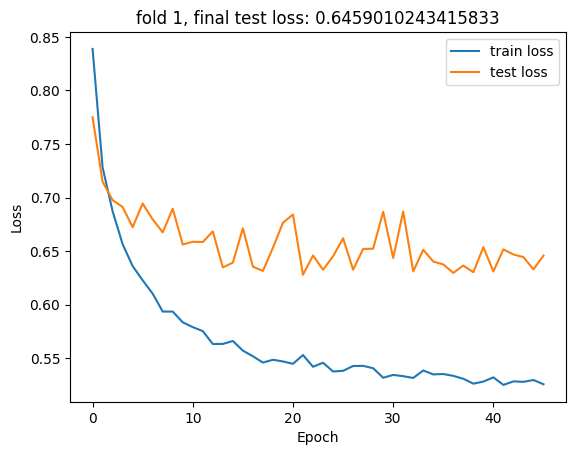

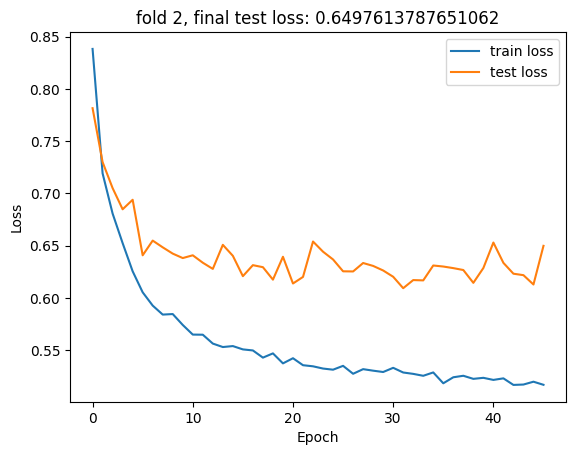

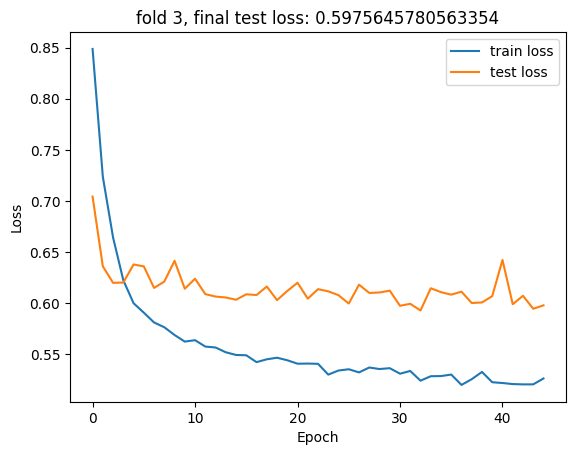

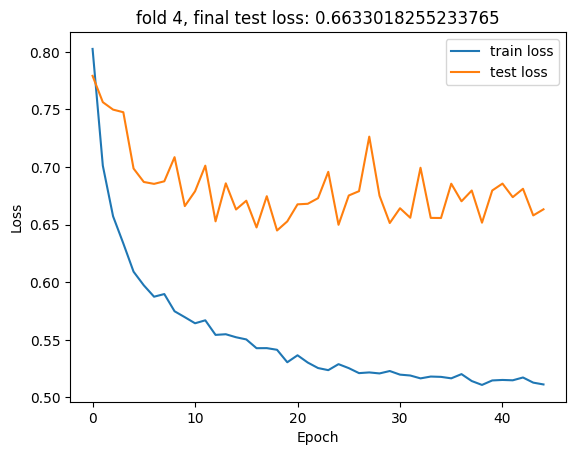

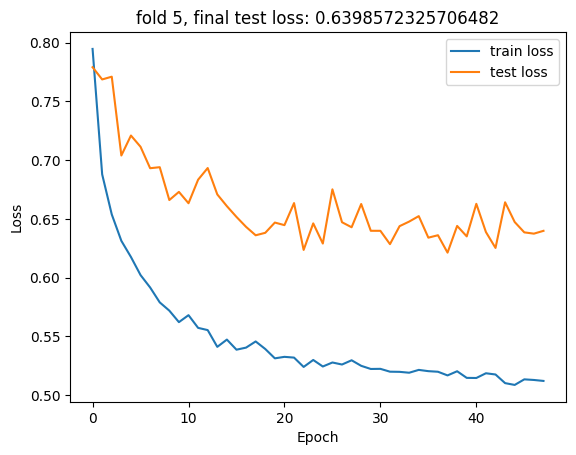

In [9]:
# plot train and test losses for each fold
plt.figure()
for i in range(n_folds):
    plt.plot(train_losses[i], label=f"train loss")
    plt.plot(test_losses[i], label=f"test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"fold {i+1}, final test loss: {test_losses[i][-1]}")
    plt.show()

In [10]:
np.mean(scores)

0.63927720785141